#### Tuesday, February 20, 2024

This notebook was referenced at the end of this [Image Similarity with Hugging Face Datasets and Transformers](https://huggingface.co/blog/image-similarity) blog post.

This all runs.

# Building an image similarity system with 🤗 Datasets FAISS

This is follow-up notebook of the tutorial introduced in [this PR](https://github.com/huggingface/notebooks/pull/270). 🤗 Datasets supports a [FAISS](https://github.com/facebookresearch/faiss) integration that is useful for building similarity systems. You can learn more about this integration [here](https://huggingface.co/docs/datasets/faiss_es).

## Installations

In [ ]:
# !pip install transformers datasets faiss-cpu -q

     |████████████████████████████████| 5.8 MB 7.4 MB/s 
     |████████████████████████████████| 451 kB 37.2 MB/s 
     |████████████████████████████████| 17.0 MB 3.7 MB/s 
     |████████████████████████████████| 182 kB 52.3 MB/s 
     |████████████████████████████████| 7.6 MB 29.7 MB/s 
     |████████████████████████████████| 212 kB 9.8 MB/s 
     |████████████████████████████████| 132 kB 18.6 MB/s 
     |████████████████████████████████| 127 kB 42.8 MB/s 


## Load model for computing embeddings of the candidate images

In [1]:
from transformers import AutoFeatureExtractor, AutoModel


model_ckpt = "nateraw/vit-base-beans"

extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

hidden_dim = model.config.hidden_size

/usr/local/lib/python3.8/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Load candidate subset

In [2]:
from datasets import load_dataset


seed = 42
num_samples = 100
dataset = load_dataset("beans", split="train")
candidate_dataset = dataset.shuffle(seed=seed).select(range(num_samples))

## Extract embeddings

In [3]:
def extract_embeddings(image):
    image_pp = extractor(image, return_tensors="pt")
    features = model(**image_pp).last_hidden_state[:, 0].detach().numpy()
    return features.squeeze()

In [4]:
# This puts a 100% load on all 8 CPU Cores.
dataset_with_embeddings = candidate_dataset.map(lambda example: {'embeddings': extract_embeddings(example["image"])})
dataset_with_embeddings.add_faiss_index(column='embeddings')

# 22.2s

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['image_file_path', 'image', 'labels', 'embeddings'],
    num_rows: 100
})

## Load test set for querying

In [5]:
test_ds = load_dataset("beans", split="test")

## Select a random sample and run the query

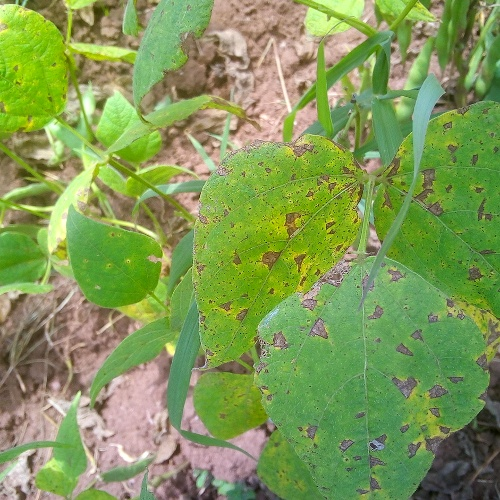

In [6]:
import numpy as np


random_index = np.random.choice(len(test_ds))
query_image = test_ds[random_index]["image"]
query_image

In [7]:
def get_neighbors(query_image, top_k=5):
    qi_embedding = model(**extractor(query_image, return_tensors="pt"))
    qi_embedding = qi_embedding.last_hidden_state[:, 0].detach().numpy().squeeze()
    scores, retrieved_examples = dataset_with_embeddings.get_nearest_examples('embeddings', qi_embedding, k=top_k)
    return scores, retrieved_examples


scores, retrieved_examples = get_neighbors(query_image)

In [8]:
# Reference:
# https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion_jax_how_to.ipynb

from PIL import Image


def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

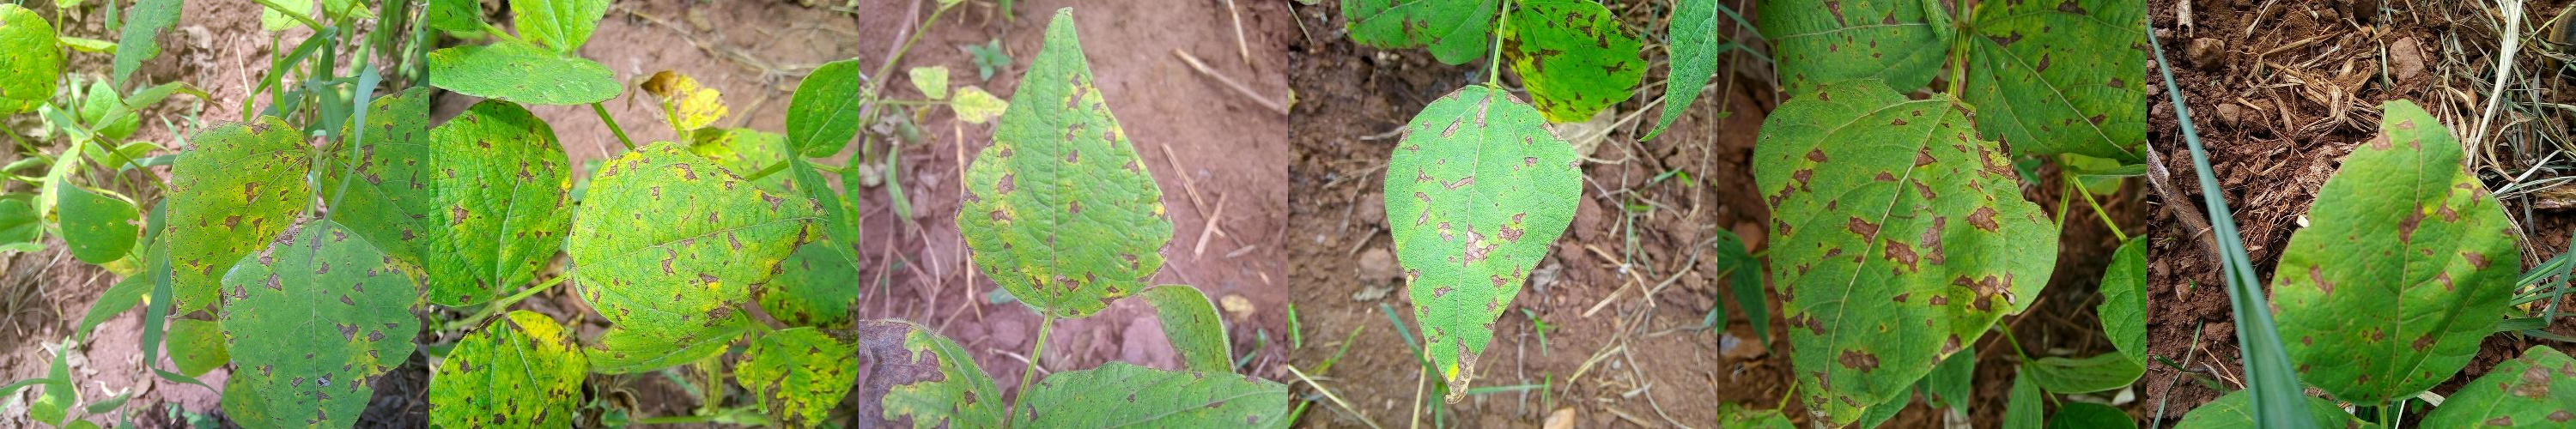

In [9]:
images = [query_image]
images.extend(retrieved_examples["image"])


image_grid(images, 1, len(images))